In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
import dotenv
dotenv.load_dotenv('../env.sh')
%run ../src/supervision.py
session = SnorkelSession()

In [2]:
classes = get_candidate_classes()
#candidate_class = classes.inducing_cytokine
#candidate_class = classes.secreted_cytokine
candidate_class = classes.inducing_transcription_factor

## Training

In [3]:
train_cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()
dev_cands = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 1).all()
len(train_cands), len(dev_cands)

(6696, 410)

In [4]:
from snorkel.annotations import load_marginals
cids_query = get_cids_query(session, candidate_class, split=0)
train_marginals = load_marginals(session, split=0, cids_query=cids_query)
len(train_marginals)

6696

In [5]:
from snorkel.annotations import load_gold_labels
cids_query = get_cids_query(session, candidate_class, split=1)
L_gold_dev = load_gold_labels(
    session, annotator_name=candidate_class.field, 
    split=1, load_as_array=True, cids_query=cids_query)
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev.shape

(410,)

In [6]:
train_marginals.shape, train_marginals.min(), train_marginals.max()

((6696,), 0.13307065943064572, 0.8407352395723052)

In [7]:
from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'n_epochs':        20,
    #'lr':              0.01,
    'lr':              0.001,
    'embedding_dim':   100,
    'hidden_dim':      100,
    'dropout':         0.5,
    'rebalance':       0.25,
    'print_freq':      1,
    'seed':            1701,
    'dev_ckpt_delay':  .1
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=1740  #epochs=20  batch size=64


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (8.77s)	Average loss=0.693251	Dev F1=18.03
[LSTM] Epoch 2 (18.78s)	Average loss=0.688029	Dev F1=24.82
[LSTM] Epoch 3 (28.75s)	Average loss=0.681911	Dev F1=23.53
[LSTM] Epoch 4 (37.87s)	Average loss=0.674705	Dev F1=31.75
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 5 (47.33s)	Average loss=0.672536	Dev F1=27.65
[LSTM] Epoch 6 (56.53s)	Average loss=0.666382	Dev F1=28.42
[LSTM] Epoch 7 (65.75s)	Average loss=0.663726	Dev F1=29.19
[LSTM] Epoch 8 (75.03s)	Average loss=0.657468	Dev F1=27.06
[LSTM] Epoch 9 (84.25s)	Average loss=0.654133	Dev F1=28.17
[LSTM] Epoch 10 (94.43s)	Average loss=0.651533	Dev F1=30.25
[LSTM] Epoch 11 (104.04s)	Average loss=0.645764	Dev F1=29.57
[LSTM] Epoch 12 (113.82s)	Average loss=0.644995	Dev F1=30.73
[LSTM] Epoch 13 (123.07s)	Average loss=0.639951	Dev F1=31.95
[LSTM] Model saved as <LSTM>
[LSTM] Epoch 14 (132.85s)	Average loss=0.640717	Dev F1=29.75
[LSTM] Epoch 15 (142.09s)	Average loss=0.639584	Dev F1=30.03
[LSTM] Epoch 16 (151.33s)	Average loss=0.634623

In [8]:
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
lstm.save('lstm_' + candidate_class.field, path)
path

[LSTM] Model saved as <lstm_inducing_transcription_factor>


'/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/model/lstm'

## Reload for Analysis

In [9]:
X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()

In [10]:
model = LSTM()
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
model.load('lstm_' + candidate_class.field, path)

[LSTM] Loaded model <lstm_inducing_transcription_factor>


In [11]:
Y = model.marginals(X)
Y.shape

(6696,)

In [12]:
Y[:10]

array([0.8683601 , 0.62817967, 0.6280985 , 0.6280891 , 0.49316046,
       0.47711357, 0.4889858 , 0.43067294, 0.6558883 , 0.7071869 ],
      dtype=float32)

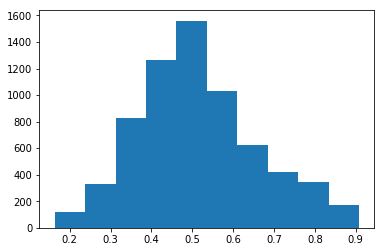

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(Y)
None

In [15]:
from snorkel import viewer
idx = np.argsort(Y)#[::-1]
idx = idx[:100]
viewer.SentenceNgramViewer(
    candidates=[X[i] for i in idx], 
    session=session
)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[18], [3, 4, 5, 6, 7], [20]], [[37], [21], [0, 34]], [[35], [74, 75, 79, 80, 88, 89…